In [217]:
import numpy as np
import time
import scipy.special
from tqdm.notebook import tqdm,trange
import matplotlib.pyplot as plt
import scipy.stats

Implemented paper: The Indian Buffet Process: An Introduction and Review 

Helpful resource:  
https://www2.bcs.rochester.edu/sites/jacobslab/cheat_sheets.html

# generate data

In [299]:
A = np.array([[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]])
def gen_data(sigma_x = 0.5, num_feature = 4, num_dim = 36, num_object = 100):
    I = sigma_x*np.ones(num_dim)
    Z = np.zeros((num_object, num_feature))
    X = np.zeros((num_object, num_dim))
    for i in range(num_object):
        while (Z[i,:].sum() == 0):
            Z[i,:] = np.random.rand(1,num_feature) > .5
        X[i,:] = np.random.randn(num_dim)*I+Z[i,:]@A
    return X, Z

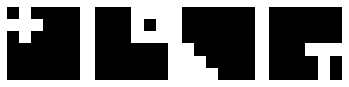

In [326]:
# the 4 features
for i in range(4):
    plt.subplot(1,4,1+i)
    plt.imshow(A[i,:].reshape(6,6), cmap='gray')
    plt.axis('off')
    

In [301]:
sigma_x = 0.3
num_feature = 4
num_dim = 36
num_object = 200
X,Z_groundtruth = gen_data(sigma_x = sigma_x, num_feature = num_feature, num_dim = num_dim, num_object = num_object)
# larger sigma_x will give larger noise

[0. 1. 0. 0.]
[1. 1. 1. 0.]
[0. 1. 1. 1.]
[1. 1. 0. 1.]


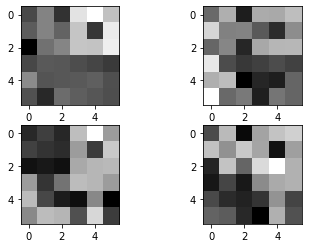

In [303]:
# show first 4 examples
for i in range(4):
    print(Z_groundtruth[i])
    plt.subplot(2,2,1+i)
    plt.imshow(X[i,:].reshape(6,6), cmap='gray')


# inference

In [304]:
def IBP(alpha = 10, num_object = 20):
    n_init = np.random.poisson(alpha)
    Z = np.zeros(shape=(num_object,n_init),dtype = np.int)
    Z[0,:] = 1
    K_plus = n_init
    for i in range(1,num_object):
        #Calculate probability of visiting past dishes
        Z[i,:] = Z.sum(axis = 0)/(i+1) > np.random.rand(1,K_plus)
        #Calculate the number of new dishes visited by customer i
        K_new = np.random.poisson(alpha/(i+1)) 
        Z=np.concatenate((Z,np.zeros(shape=(num_object,K_new),dtype = np.int)), axis=1)
        Z[i,K_plus:K_plus+K_new] = 1
        #Update matrix size and dish popularity count
        K_plus = K_plus+K_new
    return Z, K_plus

In [305]:
def cal_M_i(Z, M, i, K_plus):
    # according to equation 23, 24 line 2
    M_i = M - (M@Z[i,:].reshape(K_plus,1)@Z[i,:].reshape(1,K_plus)@M)/(Z[i,:]@M@Z[i,:].T - 1) 
    return M_i


In [306]:
def cal_M(Z, M_i, i, K_plus):
    # according to equation 23, 24 line 2
    M = M_i - (M_i@Z[i,:].reshape(K_plus,1)@Z[i,:].reshape(1,K_plus)@M_i)/(Z[i,:]@M_i@Z[i,:].T + 1)
    return M

In [307]:
def log_likelihood(X, Z, M, sigma_A, sigma_X, K_plus, num_object, num_dim):
    # according to equation 26 in page 1203
    return -1*num_object*num_dim*.5*np.log(2*np.pi) \
            - 1*(num_object - K_plus)*num_dim*np.log(sigma_X) \
            - K_plus*num_dim*np.log(sigma_A) \
            - num_dim*.5*np.log(np.linalg.det((Z.T@Z + (sigma_X**2/sigma_A**2)*np.diag(np.ones(K_plus))))) \
            + (-1/(2*sigma_X**2)) * np.trace(X.T@(np.diag(np.ones(num_object)) - Z@M@Z.T)@X)

In [308]:
# initialize 
sigma_A = 1
sigma_X = 1
alpha = 1
num_object, num_dim = X.shape
num_iter = 1000
Z, K_plus = IBP(alpha=alpha, num_object = num_object)
# pre calculate Harmonic number for N
HN = np.sum(1/np.arange(1,num_object+1))

# allocate storage
history = {}
history['Z'] = []
history['K_plus'] = []
history['sigma_X'] = []
history['sigma_A'] = []
history['alpha'] = []

for iter in trange(num_iter):
    for i in range(num_object):
        M = np.linalg.inv(Z.T@Z+np.diag(np.ones(K_plus))) # according to equation 24 line 1 in page 1204
        for k in range(K_plus):
            if k>=K_plus:
                break
            
            if Z[i,k] > 0:
                # if a feature is only possessed by one object, delete the feature column
                if Z[:,k].sum() - Z[i,k] <= 0:
                    Z[i,k] = 0
                    Z[:,k:K_plus-1] =  Z[:,k+1:]
                    K_plus = K_plus-1
                    Z = Z[:,:K_plus]
                    M = np.linalg.inv(Z.T@Z+np.diag(np.ones(K_plus))) # according to equation 24 line 1 in page 1204
                    continue
                    
            # Compute conditional distributions for the current cell in Z.
            p = np.zeros(2)
            M_i = cal_M_i(Z, M, i, K_plus) # M_i is the same for both
            
            Z[i,k] = 1
            M1 = cal_M(Z, M_i, i, K_plus)
            p[0] = log_likelihood(X, Z, M1, sigma_A, sigma_X, K_plus, num_object, num_dim) \
                    + np.log(Z[:,k].sum() - 1) - np.log(num_object)  # according to equation 22 in page 1203 and equation 18 in page 1201
            Z[i,k] = 0
            M2 = cal_M(Z, M_i, i, K_plus)
            p[1] = log_likelihood(X, Z, M2, sigma_A, sigma_X, K_plus, num_object, num_dim) \
                    + np.log(num_object - Z[:,k].sum()) - np.log(num_object)  # according to equation 22 in page 1203 and equation 18 in page 1201
            # sometimes give warnings here
            
            p = np.exp(p-p.max())
            if np.random.rand() < p[0]/p.sum():
                Z[i,k] = 1
                M = M1
            else:
                Z[i,k] = 0
                M = M2
        # Sample the number of new dishes for the current object
        K_new = K_plus # at most there won't be doubled dishes
        trun_prob = np.zeros(K_new) 
        alpha_N = alpha / num_object
        Z = np.concatenate((Z, np.zeros(shape=(num_object,K_plus),dtype = np.int)), axis=1)
        Z[i,K_plus:K_plus+K_new] = 1
        for k_i in range(K_new):
            M = np.linalg.inv(Z[:,:K_plus+k_i].T@Z[:,:K_plus+k_i] + (sigma_X**2/sigma_A**2)*np.diag(np.ones(K_plus+k_i)))
            trun_prob[k_i] = k_i*np.log(alpha_N) - alpha_N - np.log(scipy.special.factorial(k_i)) + \
                            log_likelihood(X, Z[:,:K_plus+k_i], M, sigma_A, sigma_X, K_plus+k_i, num_object, num_dim)
        trun_prob = np.exp(trun_prob-trun_prob.max())
        trun_prob = trun_prob/trun_prob.sum()
        trun_prob = np.cumsum(trun_prob)
        K_new = (trun_prob<np.random.rand()).sum()
        Z = Z[:,:K_plus+K_new]
        Z[i,K_plus:K_plus+K_new]=1
        K_plus = K_plus + K_new
        
    # Metropolis steps for sampling sigma_X and sigma_A
    M = np.linalg.inv(Z.T@Z + (sigma_X**2/sigma_A**2)*np.diag(np.ones(K_plus)))
    l_curr = log_likelihood(X, Z, M, sigma_A, sigma_X, K_plus, num_object, num_dim)
    
    if np.random.rand() < .5:
        pr_sigma_X = sigma_X - np.random.rand()/20
    else:
        pr_sigma_X = sigma_X + np.random.rand()/20
    M = np.linalg.inv(Z.T@Z + (pr_sigma_X**2/sigma_A**2)*np.diag(np.ones(K_plus)))
    l_new_X = log_likelihood(X, Z, M, sigma_A, pr_sigma_X, K_plus, num_object, num_dim)
    acc_X = np.exp(min(0, l_new_X - l_curr))
    
    if np.random.rand() < .5:
        pr_sigma_A = sigma_A - np.random.rand()/20
    else:
        pr_sigma_A = sigma_A + np.random.rand()/20
    M = np.linalg.inv(Z.T@Z + (sigma_X**2/pr_sigma_A**2)*np.diag(np.ones(K_plus)))
    l_new_A = log_likelihood(X, Z, M, pr_sigma_A, sigma_X, K_plus, num_object, num_dim)
    acc_A = np.exp(min(0, l_new_A - l_curr))    
    
    if np.random.rand() < acc_X:
        sigma_X = pr_sigma_X

    if np.random.rand() < acc_A:
        sigma_A = pr_sigma_A
        
    
    # sample alpha
    alpha = np.random.gamma(1+K_plus, 1/(1+HN))
    
    # save 
    history['Z'].append(Z)
    history['K_plus'].append(K_plus)
    history['sigma_X'].append(sigma_X)
    history['sigma_A'].append(sigma_A)
    history['alpha'].append(alpha)

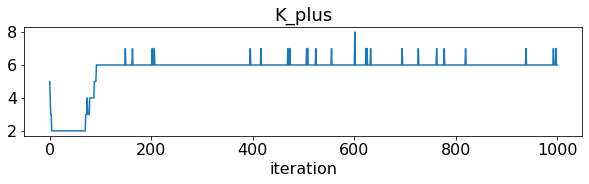

In [339]:
plt.figure(figsize = (10,2))
plt.plot(history['K_plus'])
plt.title('K_plus',fontsize=18)
plt.xlabel('iteration',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()

Text(0.5, 0, 'iteration')

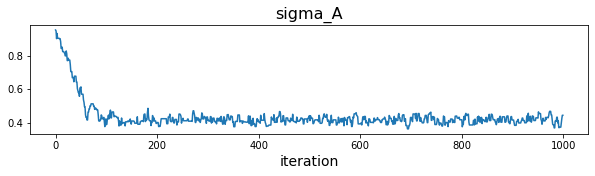

In [335]:
plt.figure(figsize = (10,2))
plt.plot(history['sigma_A'])
plt.title('sigma_A',fontsize=18)
plt.xlabel('iteration',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()

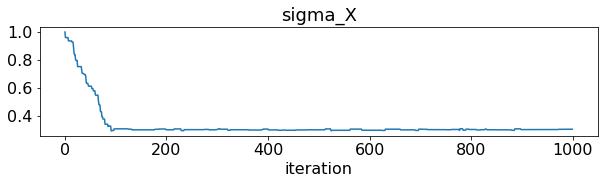

In [340]:
plt.figure(figsize = (10,2))
plt.plot(history['sigma_X'])
plt.title('sigma_X',fontsize=18)
plt.xlabel('iteration',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()

In [312]:
M = np.linalg.inv(Z.T@Z + (sigma_X**2/sigma_A**2)*np.diag(np.ones(K_plus)))

In [313]:
A_prox = M@Z.T@X
A_prox.shape

(6, 36)

In [314]:
Z.shape

(200, 6)

In [315]:
X_prox = Z@A_prox

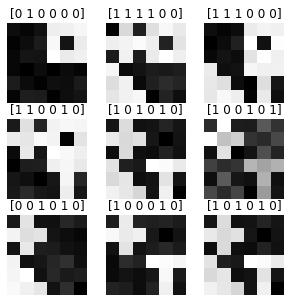

In [316]:
# show first n prediction examples
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,1+i)
    plt.imshow(X_prox[i,:].reshape(6,6), cmap='gray')
    plt.title(str(Z[i]))
    plt.axis('off')

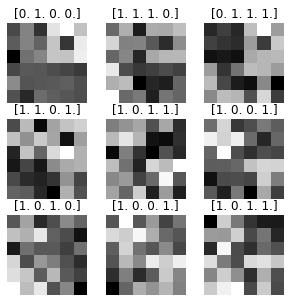

In [317]:
# show first n real examples
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,1+i)
    plt.imshow(X[i,:].reshape(6,6), cmap='gray')
    plt.title(str(Z_groundtruth[i]))    
    plt.axis('off')    

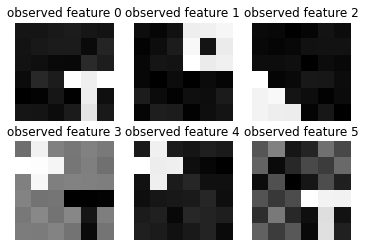

In [331]:
# show first n real examples
plt.figure(figsize=(6,4))
for i in range(A_prox.shape[0]):
    plt.subplot(2,3,1+i)
    plt.imshow(A_prox[i,:].reshape(6,6), cmap='gray')
    plt.title('observed feature '+str(i))    
    plt.axis('off')    

In [341]:
sigma_X

0.3039388316600696